> CIFAR10 dataset has 10 classes - ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

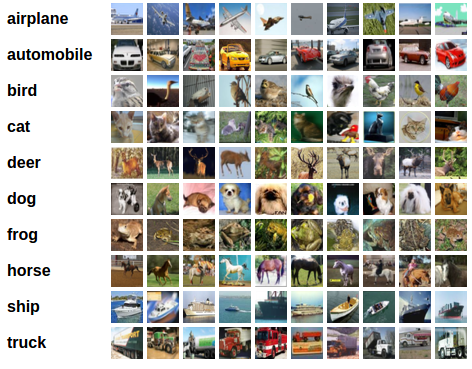

# Loading and normalizing images using TorchVision


In [1]:
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.metrics import Metric
from pytorch_lightning.loggers import TensorBoardLogger

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize(224),
     ])
path = '/raid/data/ml'
BS = 1024
trainset = torchvision.datasets.CIFAR10(root=path, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BS,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BS,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
x = trainset[0][0]
x.min(), x.max(), x.shape

(tensor(-1.), tensor(1.0000), torch.Size([3, 224, 224]))

# Displaying some images

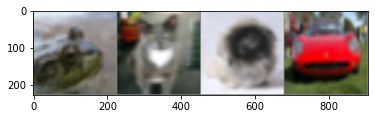

    frog      cat      dog      car


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%8s' % classes[labels[j]] for j in range(4)))

# Defining a Convolutional Neural Network

In [5]:
class FTModel(pl.LightningModule):
    def __init__(self, input_shape, num_classes, learning_rate=1e-3):
        super().__init__()
        
        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.dim = input_shape
        self.num_classes = num_classes
        
        # transfer learning if pretrained=True
        self.feature_extractor = torchvision.models.resnet18(pretrained=True)
        # layers are frozen by using eval()
        self.feature_extractor.eval()
        # freeze params
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        
        n_sizes = self._get_conv_output(input_shape)
        
        self.classifier = nn.Linear(n_sizes,num_classes)

#         self.classifier = nn.Sequential(nn.Linear(n_sizes, 256),
#                                         nn.ReLU(),
#                                         nn.Linear(256, 128),
#                                         nn.ReLU(),
#                                         nn.Linear(128,num_classes),
#                                        )
        self.n_sizes = n_sizes
  
    # returns the size of the output tensor going into the Linear layer from the conv block.
    def _get_conv_output(self, shape):
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self._forward_features(tmp_input) 
        print("bottleneck output size",output_feat.shape)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
        
    # returns the feature tensor from the conv block
    def _forward_features(self, x):
        with torch.no_grad():
            x = self.feature_extractor(x)
        return x
    
    # will be used during inference
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def training_step(self, batch, batch_nb):
        x,y = batch
        yp = self(x)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(yp, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def predict_step(self, batch, batch_nb, dataloader_idx):
        x,y = batch
        yp = self(x)
        return yp
    
    def configure_optimizers(self):
        adam = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=0)
        return adam
    

In [6]:
net = FTModel((3,224,224),10,2e-4)

bottleneck output size torch.Size([1, 1000])


/raid/data/ml/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [7]:
net.n_sizes

1000

In [8]:
net.summarize()


  | Name              | Type   | Params
---------------------------------------------
0 | feature_extractor | ResNet | 11.7 M
1 | classifier        | Linear | 10.0 K
---------------------------------------------
10.0 K    Trainable params
11.7 M    Non-trainable params
11.7 M    Total params
46.798    Total estimated model params size (MB)


  | Name              | Type   | Params
---------------------------------------------
0 | feature_extractor | ResNet | 11.7 M
1 | classifier        | Linear | 10.0 K
---------------------------------------------
10.0 K    Trainable params
11.7 M    Non-trainable params
11.7 M    Total params
46.798    Total estimated model params size (MB)

# Finally we will train our neural network

In [9]:
epochs = 5
trainer = pl.Trainer(gpus=1, max_epochs=epochs, #accelerator='dp',
                     progress_bar_refresh_rate=20,precision=16)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


In [10]:
%%time
trainer.fit(net, trainloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6,7]

  | Name              | Type   | Params
---------------------------------------------
0 | feature_extractor | ResNet | 11.7 M
1 | classifier        | Linear | 10.0 K
---------------------------------------------
10.0 K    Trainable params
11.7 M    Non-trainable params
11.7 M    Total params
46.798    Total estimated model params size (MB)
/raid/data/ml/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

CPU times: user 52.2 s, sys: 41 s, total: 1min 33s
Wall time: 3min 37s


In [11]:
yp = trainer.predict(net,testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6,7]
/raid/data/ml/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 49it [00:00, ?it/s]

In [12]:
yp = torch.cat(yp,dim=0)
yp.shape

torch.Size([10000, 10])

In [13]:
ytest = [y for _,y in testloader]
ytest = torch.cat(ytest,dim=0)
ytest.shape

torch.Size([10000])

In [14]:
"Accuracy",(yp.argmax(dim=1) == ytest.cuda()).float().mean()

('Accuracy', tensor(0.7706, device='cuda:0'))

# Let's test the accuracy of the model

**Displaying an image from test set**

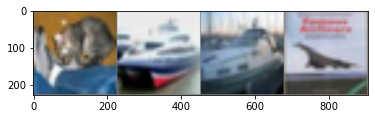

GroundTruth:    cat  ship  ship plane


In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

**We will now see how the neural network predicts the above image**

In [16]:
net = net.cuda()
outputs = net(images.cuda())

**The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:**

In [17]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j].cpu()]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


**Let us look at how the network performs on the whole dataset.**

In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().cpu().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 77 %


**Let's see which classes performed well individually**

In [19]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 75 %
Accuracy of   car : 66 %
Accuracy of  bird : 100 %
Accuracy of   cat : 85 %
Accuracy of  deer : 100 %
Accuracy of   dog : 50 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 85 %
Accuracy of truck : 83 %


### Training with DP is neither faster nor better. 
- 1 GPU: Training time 3 min 38s Accuracy 77%
- DP 4 GPUs: Training time 3min 52s Accuracy 76%